In [31]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
 
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
 
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'   # 0 = all messages, 3 = only errors
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import GlobalAveragePooling2D

In [16]:
train_dir = '/kaggle/input/dogs-vs-cats/dataset/train'
val_dir = '/kaggle/input/dogs-vs-cats/dataset/validation'
test_dir ='/kaggle/input/dogs-vs-cats/dataset/test'

In [18]:
class_names = ['Cat', 'Dog']
 
datagen = ImageDataGenerator(rescale=1./255)
# Генератор для тренування з аугментацією + нормалізацією для VGG16

train_datagen = ImageDataGenerator(

    preprocessing_function=preprocess_input,

    rotation_range=20,

    width_shift_range=0.1,

    height_shift_range=0.1,

    shear_range=0.1,

    zoom_range=0.1,

    horizontal_flip=True

)
 
# Генератор для валідації і тесту — тільки нормалізація

val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
 
# Генератор для тренувального набору

train_generator = train_datagen.flow_from_directory(

    train_dir,

    target_size=(224, 224),  # Рекомендований розмір для VGG16

    batch_size=32,

    class_mode='binary',

    shuffle=True

)
 
# Генератор для валідаційного набору

val_generator = val_test_datagen.flow_from_directory(

    val_dir,

    target_size=(224, 224),

    batch_size=32,

    class_mode='binary',

    shuffle=False

)
 
# Генератор для тестового набору

test_generator = val_test_datagen.flow_from_directory(

    test_dir,

    target_size=(224, 224),

    batch_size=32,

    class_mode='binary',

    shuffle=False

)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12461 images belonging to 2 classes.


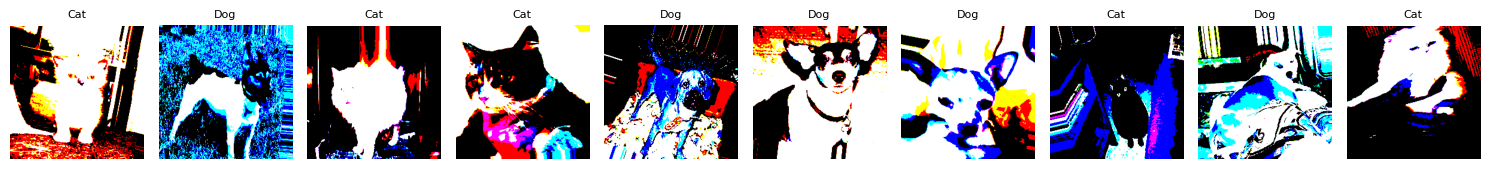

In [19]:
images, labels = next(train_generator)
 
# Випадкові індекси для 10 зображень
indices = np.random.choice(len(images), size=10, replace=False)
 
# Візуалізація
plt.figure(figsize=(15, 3))
for i, idx in enumerate(indices):
    plt.subplot(1, 10, i + 1)
    plt.imshow(images[idx])
    plt.axis('off')
    plt.title(class_names[int(labels[idx])], fontsize=8)
plt.tight_layout()
plt.show()

In [20]:
base_model = VGG16(
    weights='imagenet',
    include_top=False,           # Ми додаємо свої класифікатори
    input_shape=(224, 224, 3)
)
 
# Заморожуємо всі шари базової VGG16
for layer in base_model.layers:
    layer.trainable = False

In [21]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
 
model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 21,137,729 (80.63 MB)

 Trainable params: 6,423,041 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [24]:
early_stopping = EarlyStopping(
    monitor='val_loss',       # Слідкуємо за валідаційною втратою
    patience=5,               # Скільки епох чекати без покращення
    restore_best_weights=True
)
 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,               # Зменшення LR у 5 разів
    patience=3,               # Якщо за 3 епохи немає покращення
    min_lr=1e-6               # Мінімально допустимий learning rate
)

In [25]:
history = model.fit(

    train_generator,

    steps_per_epoch=len(train_generator),

    epochs=50,

    validation_data=val_generator,

    validation_steps=len(val_generator),

    callbacks=[early_stopping, reduce_lr]

)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 239s 378ms/step - accuracy: 0.9210 - loss: 0.9925 - val_accuracy: 0.9786 - val_loss: 0.1141 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 237s 380ms/step - accuracy: 0.9698 - loss: 0.1157 - val_accuracy: 0.9834 - val_loss: 0.0721 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 376ms/step - accuracy: 0.9749 - loss: 0.0759 - val_accuracy: 0.9838 - val_loss: 0.0645 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 235s 377ms/step - accuracy: 0.9786 - loss: 0.0606 - val_accuracy: 0.9836 - val_loss: 0.0597 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 234s 375ms/step - accuracy: 0.9837 - loss: 0.0460 - val_accuracy: 0.9846 - val_loss: 0.0564 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 233s 373ms/step - accuracy: 0.9830 - loss: 0.0472 - val_accuracy: 0.9856 - val_loss: 0.0544 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [26]:
model.save('/kaggle/working/vgg16_cats_dogs.h5')

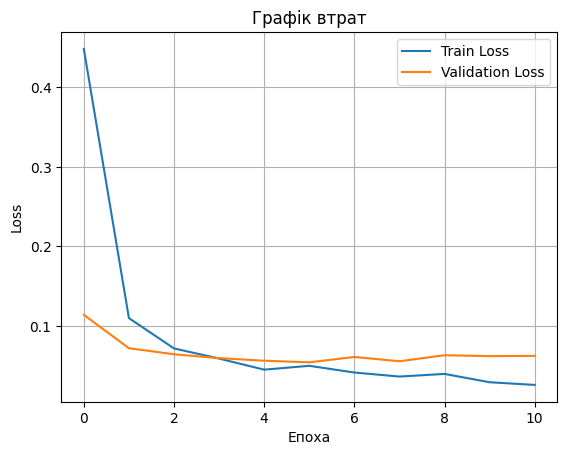

In [27]:
# Побудова графіку втрат (loss)
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Графік втрат')
plt.xlabel('Епоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

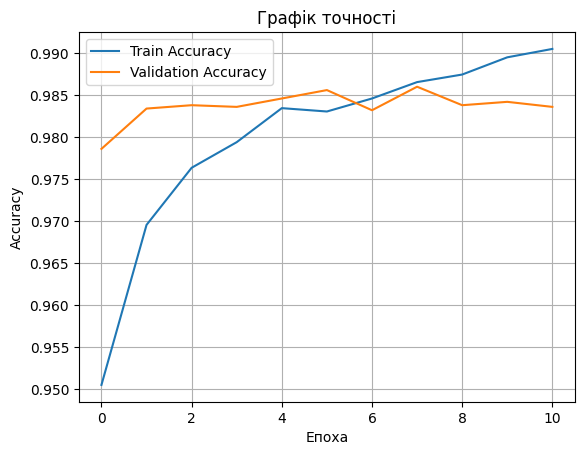

In [28]:
# Побудова графіку точності (accuracy)
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Графік точності')
plt.xlabel('Епоха')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Завантаження базової VGG16 без класифікатора
base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
 
# ❄️ Заморожуємо тільки нижні шари, а верхні розморозимо для fine-tuning
for layer in base_model.layers[:15]:
    layer.trainable = False
for layer in base_model.layers[15:]:
    layer.trainable = True
 
# 🔁 Замість Flatten краще використовувати GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)
 
# Створення фінальної моделі
model = Model(inputs=base_model.input, outputs=predictions)

In [37]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [38]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

In [39]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 244s 383ms/step - accuracy: 0.9406 - loss: 0.1776 - val_accuracy: 0.9828 - val_loss: 0.0581 - learning_rate: 1.0000e-04
Epoch 2/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 381ms/step - accuracy: 0.9810 - loss: 0.0520 - val_accuracy: 0.9844 - val_loss: 0.0608 - learning_rate: 1.0000e-04
Epoch 3/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 238s 380ms/step - accuracy: 0.9822 - loss: 0.0491 - val_accuracy: 0.9838 - val_loss: 0.0483 - learning_rate: 1.0000e-04
Epoch 4/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 237s 379ms/step - accuracy: 0.9890 - loss: 0.0333 - val_accuracy: 0.9856 - val_loss: 0.0455 - learning_rate: 1.0000e-04
Epoch 5/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 377ms/step - accuracy: 0.9876 - loss: 0.0320 - val_accuracy: 0.9846 - val_loss: 0.0513 - learning_rate: 1.0000e-04
Epoch 6/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 236s 377ms/step - accuracy: 0.9911 - loss: 0.0254 - val_accuracy: 0.9878 - val_loss: 0.0575 - learning_rate: 1.0000e-04
Epoch 7/50
625/625 ━━━━━━━━━━━━━━━━━━━━ 

In [40]:
# Збереження моделі
model.save('/kaggle/working/vgg16_finetuned.h5')

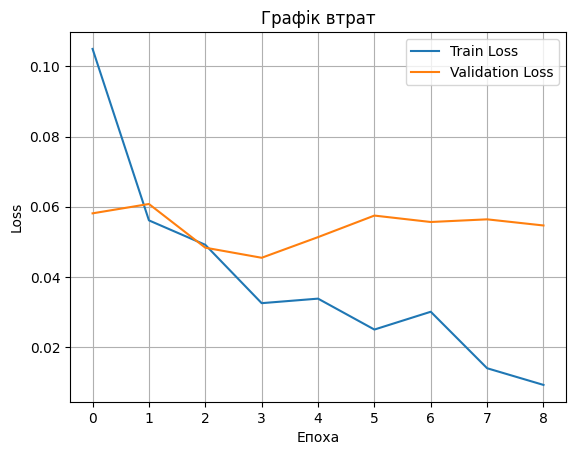

In [41]:
# Побудова графіку втрат (loss)
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Графік втрат')
plt.xlabel('Епоха')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

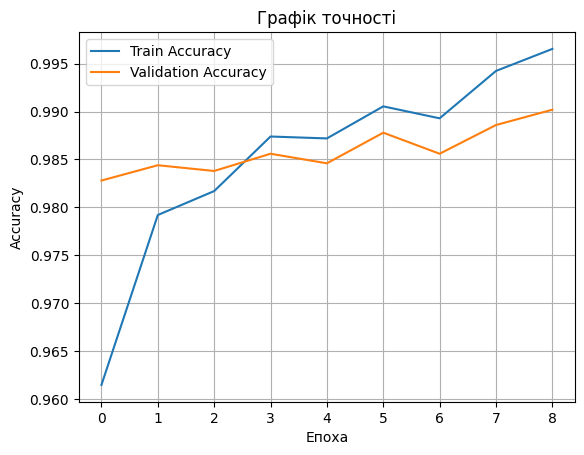

In [42]:
# Побудова графіку точності (accuracy)
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Графік точності')
plt.xlabel('Епоха')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 681ms/step


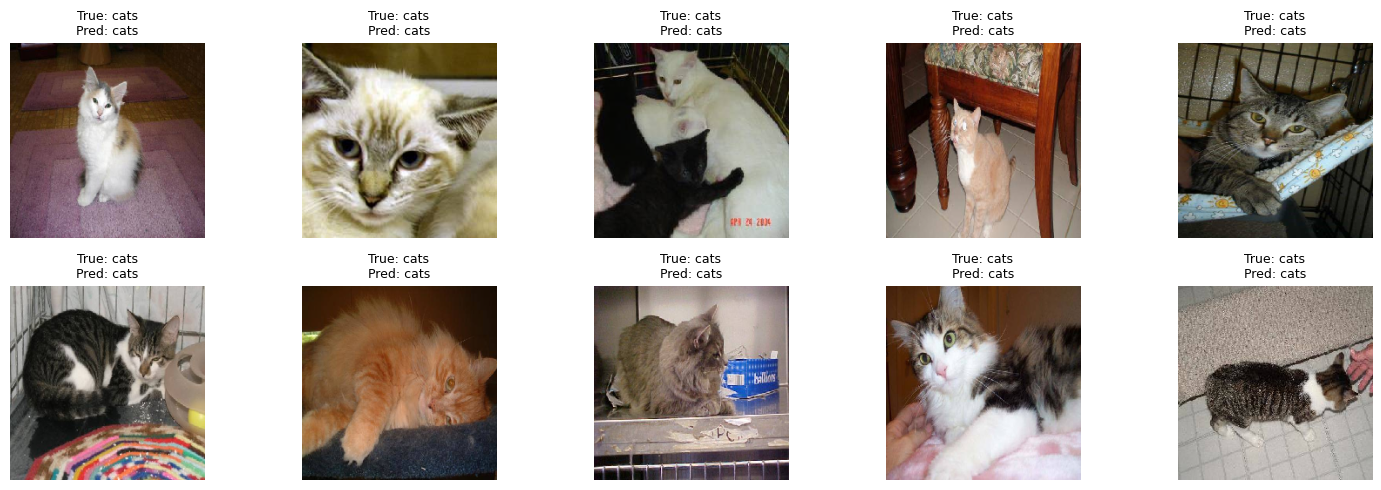

In [43]:
# Повертаємо генератор у початок (на всяк випадок)
test_generator.reset()
 
# Отримуємо один batch із тестового генератора
images, true_labels = next(test_generator)
 
# Робимо передбачення
pred_probs = model.predict(images)
pred_labels = (pred_probs > 0.5).astype(int).reshape(-1)
 
# Отримуємо відповідність індексів класів
inv_class_indices = {v: k for k, v in test_generator.class_indices.items()}
class_names = [inv_class_indices[0], inv_class_indices[1]]  # ['Cat', 'Dog']
 
# Показуємо перші 10 зображень
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Зображення після VGG16-preprocessing будуть зі зміненими значеннями
    # Повертаємо до нормального вигляду, якщо потрібно
    img = images[i].copy()
    img = img + [103.939, 116.779, 123.68]  # додаємо mean (VGG16)
    img = img[..., ::-1]  # з BGR → RGB
    img = np.clip(img / 255.0, 0, 1)  # для відображення
 
    plt.imshow(img)
    plt.axis('off')
    true_class = class_names[int(true_labels[i])]
    pred_class = class_names[int(pred_labels[i])]
    plt.title(f"True: {true_class}\nPred: {pred_class}", fontsize=9)
plt.tight_layout()
plt.show()

**Висновок:**
У цій лабораторній ми навчились використовувати модель VGG16 для класифікації зображень котів і собак. Завантажили та підготували дані, створили генератори з аугментацією, побудували і навчили модель. Спочатку ми використали VGG16 без змін і додали свої шари — точність була 98.4%. Потім дозволили моделі трохи донавчитись і змінили один шар — точність піднялась до 99.02%.